In [1]:
import numpy as np

In [2]:
import networkx as nx

In [3]:
import math
import dill
from pyomo import environ as pyo

In [4]:
from importlib.resources import files

In [5]:
from interarray.interarraylib import L_from_site, as_normalized, G_from_S, NodeTagger, S_from_G
from interarray.svg import svgplot
from interarray.plotting import gplot, pplot
from interarray.mesh import make_planar_embedding
from interarray.baselines.hgs import iterative_hgs_cvrp, hgs_multiroot
from interarray.importer import load_repository, L_from_yaml
from interarray.pathfinding import PathFinder

In [6]:
import interarray.MILP.pyomo as omo

In [7]:
from matplotlib import pyplot as plt

In [8]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

In [9]:
F = NodeTagger()

In [10]:
solver = pyo.SolverFactory('gurobi', solver_io='python')

## Reference solution

Yi, X., Scutariu, M., & Smith, K. (2019). Optimisation of offshore wind farm inter-array collection system. IET Renewable Power Generation, 13(11), 1990–1999. https://doi.org/10.1049/iet-rpg.2018.5805

The network was not parsed from the paper, using the published total cable lengths:
- radial: 162.3 km
- branched: 154.6 km

## Start here

In [12]:
base_dir = files('interarray.data')
inputfile = base_dir / 'Yi-2019.yaml'
L = L_from_yaml(inputfile)

In [13]:
P, A = make_planar_embedding(L)

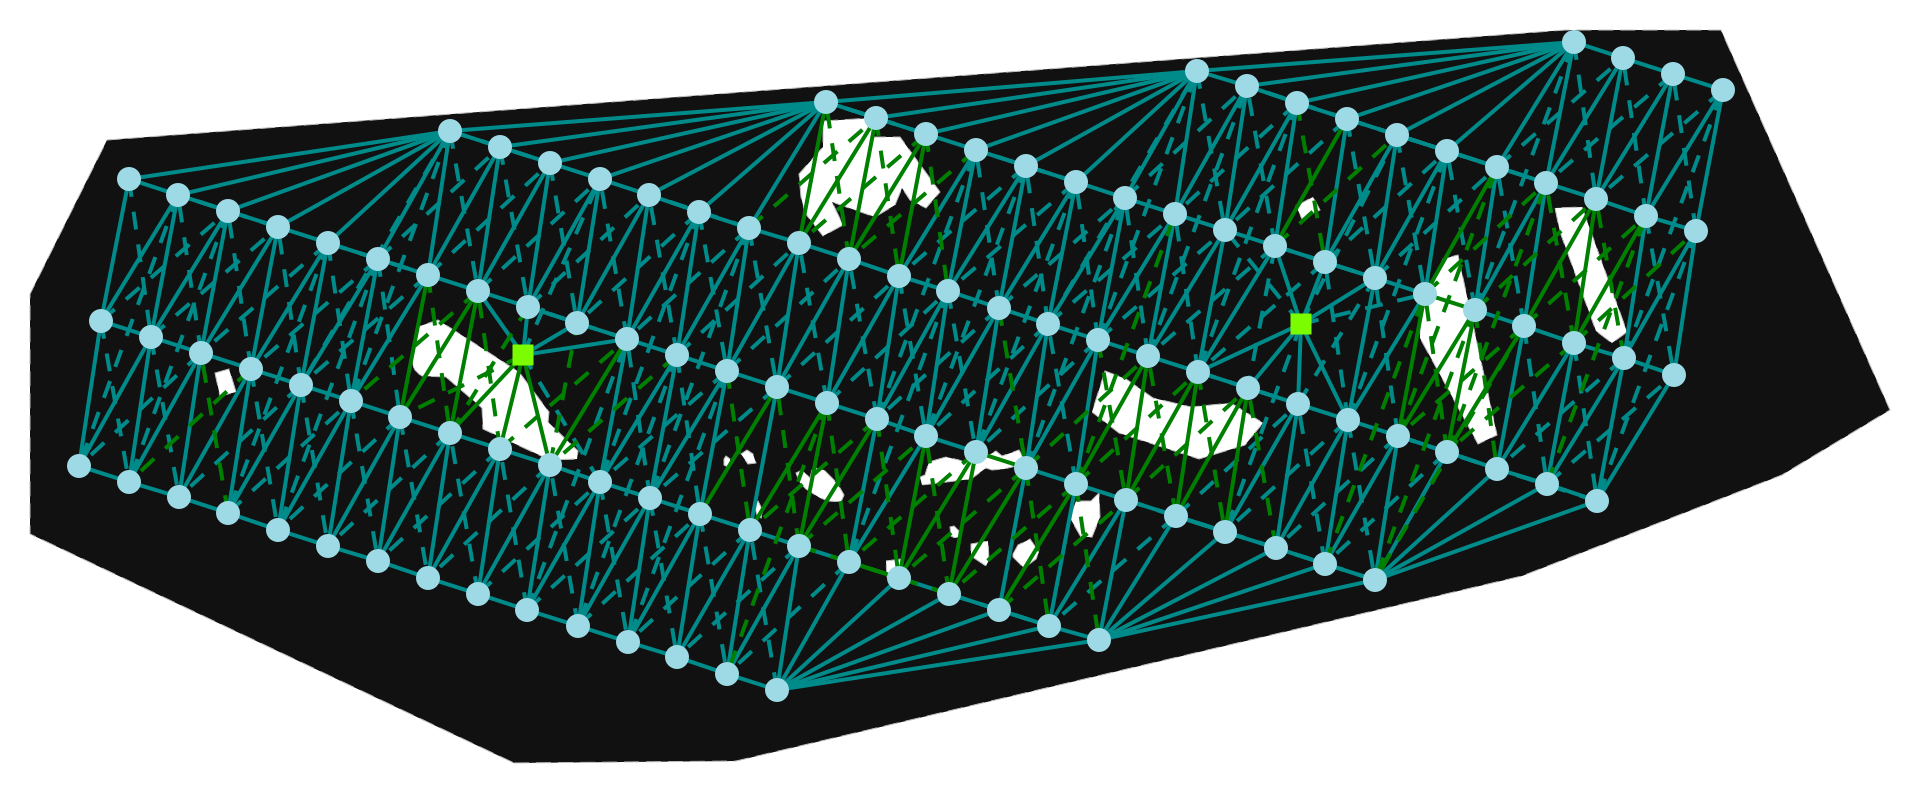

In [15]:
svgplot(A)

## Solve κ = 6 (branched)

In [14]:
Sʹ = hgs_multiroot(A, capacity=6, time_limit=0.5)

In [15]:
Sʹ.graph['solution_time']

(0.04, 0.22)

In [16]:
Gʹ = G_from_S(Sʹ, A)

In [17]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

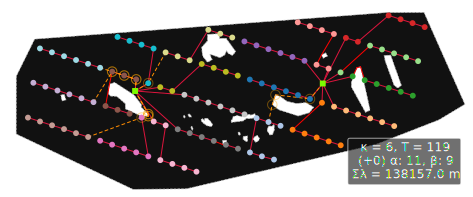

In [18]:
gplot(Hʹ);

In [14]:
1 - 138157/154600

0.10635834411384215

In [34]:
capacity = 6
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    gates_limit=True,
    branching=True
)
# omo.warmup_model(model, Sʹ)  # warm-start hinders Gurobi in this instance

In [35]:
solver.options.mipgap = 0.005  # 0.5 %
solver.options.timelimit = 45  # [s]
solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=2, T=119, k=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 45
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  45
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 3971 rows, 2592 columns and 14780 nonzeros
Model fingerprint: 0x730fe10f
Variable types: 0 continuous, 2592 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [7e+02, 2e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 534 rows and 0 columns
Presolve time: 0.02s
Presolved: 3437 rows, 2592 columns, 12182 

Non-default parameters:


TimeLimit  10


MIPGap  0.005


MIPFocus  1


Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk


Optimize a model with 4417 rows, 2880 columns and 16454 nonzeros


Model fingerprint: 0x8f3bdc8b


Variable types: 0 continuous, 2880 integer (1440 binary)


Coefficient statistics:


  Matrix range     [1e+00, 5e+00]


  Objective range  [4e+02, 1e+04]


  Bounds range     [1e+00, 5e+00]


  RHS range        [1e+00, 1e+02]


Loaded user MIP start with objective 136736


Presolve removed 645 rows and 0 columns


Presolve time: 0.02s


Presolved: 3772 rows, 2880 columns, 13726 nonzeros


Variable types: 0 continuous, 2880 integer (1440 binary)


Root relaxation: objective 1.199416e+05, 3123 iterations, 0.05 seconds (0.06 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0 119941.581    0  211 136736.421 119941.581  12.3%     -    0s


H    0     0                    134676.90352 119941.581  10.9%     -    0s


H    0     0                    134673.93542 119941.581  10.9%     -    0s


H    0     0                    134605.81407 119941.581  10.9%     -    0s


H    0     0                    134534.51007 119941.581  10.8%     -    0s


H    0     0                    134173.76060 119941.581  10.6%     -    0s


H    0     0                    133563.67259 119941.581  10.2%     -    0s


H    0     0                    132701.02215 121414.824  8.50%     -    0s


H    0     0                    132655.51839 121414.824  8.47%     -    0s


H    0     0                    132541.27477 121414.824  8.39%     -    0s


H    0     0                    132035.95651 121414.824  8.04%     -    0s


     0     0 121414.824    0  413 132035.957 121414.824  8.04%     -    0s


H    0     0                    130754.02504 121414.824  7.14%     -    0s


H    0     0                    130750.11977 121414.824  7.14%     -    0s


H    0     0                    129850.21573 121414.824  6.50%     -    0s


H    0     0                    129781.10122 121414.824  6.45%     -    0s


     0     0 121738.879    0  396 129781.101 121738.879  6.20%     -    0s


     0     0 121747.638    0  410 129781.101 121747.638  6.19%     -    0s


     0     0 121749.217    0  408 129781.101 121749.217  6.19%     -    0s


     0     0 121749.392    0  408 129781.101 121749.392  6.19%     -    0s


H    0     0                    129716.14888 122246.118  5.76%     -    0s


H    0     0                    129105.60997 122246.118  5.31%     -    0s


     0     0 122267.871    0  416 129105.610 122267.871  5.30%     -    0s


H    0     0                    128794.28991 122337.438  5.01%     -    0s


     0     0 122337.438    0  436 128794.290 122337.438  5.01%     -    0s


H    0     0                    128793.04523 122338.574  5.01%     -    0s


     0     0 122338.574    0  441 128793.045 122338.574  5.01%     -    0s


     0     0 122339.044    0  436 128793.045 122339.044  5.01%     -    0s


H    0     0                    128327.73138 122547.173  4.50%     -    0s


H    0     0                    128167.38786 122547.173  4.39%     -    0s


     0     0 122547.173    0  493 128167.388 122547.173  4.39%     -    0s


H    0     0                    128028.61085 122547.173  4.28%     -    0s


H    0     0                    127868.26732 122547.173  4.16%     -    0s


     0     0 122604.584    0  526 127868.267 122604.584  4.12%     -    0s


     0     0 122614.525    0  519 127868.267 122614.525  4.11%     -    0s


     0     0 122616.019    0  527 127868.267 122616.019  4.11%     -    0s


     0     0 122616.721    0  531 127868.267 122616.721  4.11%     -    0s


     0     0 122616.743    0  533 127868.267 122616.743  4.11%     -    0s


     0     0 122794.639    0  525 127868.267 122794.639  3.97%     -    1s


     0     0 122851.580    0  538 127868.267 122851.580  3.92%     -    1s


     0     0 122858.164    0  545 127868.267 122858.164  3.92%     -    1s


     0     0 122862.404    0  549 127868.267 122862.404  3.91%     -    1s


     0     0 122862.909    0  556 127868.267 122862.909  3.91%     -    1s


     0     0 122942.379    0  542 127868.267 122942.379  3.85%     -    1s


H    0     0                    127843.23159 122942.379  3.83%     -    1s


H    0     0                    127690.35093 122942.379  3.72%     -    2s


H    0     0                    127587.42735 122942.379  3.64%     -    3s


H    0     0                    127541.36459 122942.379  3.61%     -    3s


     0     2 122942.379    0  541 127541.365 122942.379  3.61%     -    4s


H   71    83                    127421.54307 123015.252  3.46%  93.9    4s


   156   176 123338.796   17  455 127421.543 123015.252  3.46%  95.6    5s


H  176   186                    127326.29990 123015.252  3.39%  95.6    5s


H  190   194                    127037.61981 123015.252  3.17%  97.9    5s


H  612   573                    127025.71515 123015.252  3.16%  80.9    6s


H  614   587                    126812.62095 123015.252  2.99%  81.0    6s


H  706   630                    126525.66791 123015.252  2.77%  79.0    6s


H  799   694                    126436.24506 123035.885  2.69%  77.3    7s


H  869   734                    126432.37395 123044.458  2.68%  76.4    7s


H  927   734                    125826.22547 123044.458  2.21%  76.5    7s


H 1029   759                    125496.03183 123044.458  1.95%  77.0    9s


  1273   893 123217.221   10  443 125496.032 123070.051  1.93%  73.1   10s


Cutting planes:


  Gomory: 28


  Lift-and-project: 10


  Cover: 3


  MIR: 293


  StrongCG: 4


  Flow cover: 85


  Flow path: 7


  Zero half: 2


  Network: 16


  Relax-and-lift: 2


Explored 1284 nodes (100186 simplex iterations) in 10.03 seconds (12.92 work units)


Thread count was 16 (of 16 available processors)


Solution count 10: 125496 125826 126432 ... 127422


Time limit reached


Best objective 1.254960318323e+05, best bound 1.230700509573e+05, gap 1.9331%


containing a solution


In [36]:
H = omo.gurobi_investigate_pool(P, A, model, solver, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 133885.478
Pool investigation over - next best undetoured length: 134188.670


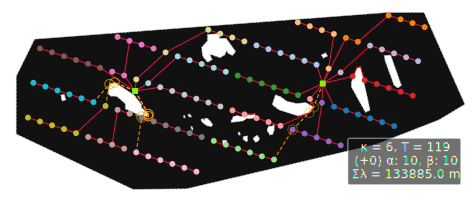

In [37]:
ax = gplot(H)

In [11]:
1 - 133885/154600

0.13399094437257442

In [38]:
with open('yi_2019_κ_6_branched_ours.dill', 'wb') as outfile:
    dill.dump(H, outfile)

## Solve κ = 6 (radial)

In [13]:
Sʹ = hgs_multiroot(A, capacity=6, time_limit=0.5)

In [14]:
Sʹ.graph['solution_time']

(0.04, 0.23)

In [15]:
Gʹ = G_from_S(Sʹ, A)

In [16]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

<Axes: >

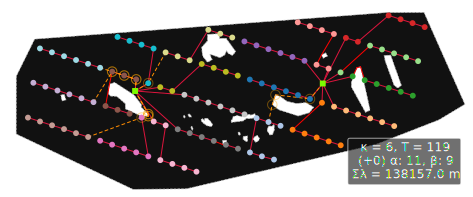

In [17]:
gplot(Hʹ)

In [13]:
1 - 138157/162300

0.1487553912507702

In [22]:
capacity = 6
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    gates_limit=True,
    branching=False
)
omo.warmup_model(model, Sʹ)

In [23]:
solver.options.mipgap = 0.005  # 0.5 %
solver.options.timelimit = 45  # [s]
solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=2, T=119, k=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 45
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  45
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4090 rows, 2592 columns and 15838 nonzeros
Model fingerprint: 0xc57a99b1
Variable types: 0 continuous, 2592 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [7e+02, 2e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 134833

Presolve removed 534 rows and 0 columns
Presolve time: 0.

Non-default parameters:


TimeLimit  10


MIPGap  0.005


MIPFocus  1


Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk


Optimize a model with 4417 rows, 2880 columns and 16454 nonzeros


Model fingerprint: 0x8f3bdc8b


Variable types: 0 continuous, 2880 integer (1440 binary)


Coefficient statistics:


  Matrix range     [1e+00, 5e+00]


  Objective range  [4e+02, 1e+04]


  Bounds range     [1e+00, 5e+00]


  RHS range        [1e+00, 1e+02]


Loaded user MIP start with objective 136736


Presolve removed 645 rows and 0 columns


Presolve time: 0.02s


Presolved: 3772 rows, 2880 columns, 13726 nonzeros


Variable types: 0 continuous, 2880 integer (1440 binary)


Root relaxation: objective 1.199416e+05, 3123 iterations, 0.05 seconds (0.06 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0 119941.581    0  211 136736.421 119941.581  12.3%     -    0s


H    0     0                    134676.90352 119941.581  10.9%     -    0s


H    0     0                    134673.93542 119941.581  10.9%     -    0s


H    0     0                    134605.81407 119941.581  10.9%     -    0s


H    0     0                    134534.51007 119941.581  10.8%     -    0s


H    0     0                    134173.76060 119941.581  10.6%     -    0s


H    0     0                    133563.67259 119941.581  10.2%     -    0s


H    0     0                    132701.02215 121414.824  8.50%     -    0s


H    0     0                    132655.51839 121414.824  8.47%     -    0s


H    0     0                    132541.27477 121414.824  8.39%     -    0s


H    0     0                    132035.95651 121414.824  8.04%     -    0s


     0     0 121414.824    0  413 132035.957 121414.824  8.04%     -    0s


H    0     0                    130754.02504 121414.824  7.14%     -    0s


H    0     0                    130750.11977 121414.824  7.14%     -    0s


H    0     0                    129850.21573 121414.824  6.50%     -    0s


H    0     0                    129781.10122 121414.824  6.45%     -    0s


     0     0 121738.879    0  396 129781.101 121738.879  6.20%     -    0s


     0     0 121747.638    0  410 129781.101 121747.638  6.19%     -    0s


     0     0 121749.217    0  408 129781.101 121749.217  6.19%     -    0s


     0     0 121749.392    0  408 129781.101 121749.392  6.19%     -    0s


H    0     0                    129716.14888 122246.118  5.76%     -    0s


H    0     0                    129105.60997 122246.118  5.31%     -    0s


     0     0 122267.871    0  416 129105.610 122267.871  5.30%     -    0s


H    0     0                    128794.28991 122337.438  5.01%     -    0s


     0     0 122337.438    0  436 128794.290 122337.438  5.01%     -    0s


H    0     0                    128793.04523 122338.574  5.01%     -    0s


     0     0 122338.574    0  441 128793.045 122338.574  5.01%     -    0s


     0     0 122339.044    0  436 128793.045 122339.044  5.01%     -    0s


H    0     0                    128327.73138 122547.173  4.50%     -    0s


H    0     0                    128167.38786 122547.173  4.39%     -    0s


     0     0 122547.173    0  493 128167.388 122547.173  4.39%     -    0s


H    0     0                    128028.61085 122547.173  4.28%     -    0s


H    0     0                    127868.26732 122547.173  4.16%     -    0s


     0     0 122604.584    0  526 127868.267 122604.584  4.12%     -    0s


     0     0 122614.525    0  519 127868.267 122614.525  4.11%     -    0s


     0     0 122616.019    0  527 127868.267 122616.019  4.11%     -    0s


     0     0 122616.721    0  531 127868.267 122616.721  4.11%     -    0s


     0     0 122616.743    0  533 127868.267 122616.743  4.11%     -    0s


     0     0 122794.639    0  525 127868.267 122794.639  3.97%     -    1s


     0     0 122851.580    0  538 127868.267 122851.580  3.92%     -    1s


     0     0 122858.164    0  545 127868.267 122858.164  3.92%     -    1s


     0     0 122862.404    0  549 127868.267 122862.404  3.91%     -    1s


     0     0 122862.909    0  556 127868.267 122862.909  3.91%     -    1s


     0     0 122942.379    0  542 127868.267 122942.379  3.85%     -    1s


H    0     0                    127843.23159 122942.379  3.83%     -    1s


H    0     0                    127690.35093 122942.379  3.72%     -    2s


H    0     0                    127587.42735 122942.379  3.64%     -    3s


H    0     0                    127541.36459 122942.379  3.61%     -    3s


     0     2 122942.379    0  541 127541.365 122942.379  3.61%     -    4s


H   71    83                    127421.54307 123015.252  3.46%  93.9    4s


   156   176 123338.796   17  455 127421.543 123015.252  3.46%  95.6    5s


H  176   186                    127326.29990 123015.252  3.39%  95.6    5s


H  190   194                    127037.61981 123015.252  3.17%  97.9    5s


H  612   573                    127025.71515 123015.252  3.16%  80.9    6s


H  614   587                    126812.62095 123015.252  2.99%  81.0    6s


H  706   630                    126525.66791 123015.252  2.77%  79.0    6s


H  799   694                    126436.24506 123035.885  2.69%  77.3    7s


H  869   734                    126432.37395 123044.458  2.68%  76.4    7s


H  927   734                    125826.22547 123044.458  2.21%  76.5    7s


H 1029   759                    125496.03183 123044.458  1.95%  77.0    9s


  1273   893 123217.221   10  443 125496.032 123070.051  1.93%  73.1   10s


Cutting planes:


  Gomory: 28


  Lift-and-project: 10


  Cover: 3


  MIR: 293


  StrongCG: 4


  Flow cover: 85


  Flow path: 7


  Zero half: 2


  Network: 16


  Relax-and-lift: 2


Explored 1284 nodes (100186 simplex iterations) in 10.03 seconds (12.92 work units)


Thread count was 16 (of 16 available processors)


Solution count 10: 125496 125826 126432 ... 127422


Time limit reached


Best objective 1.254960318323e+05, best bound 1.230700509573e+05, gap 1.9331%


containing a solution


In [24]:
H = omo.gurobi_investigate_pool(P, A, model, solver, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 134583.002
Incumbent has (detoured) length: 134510.903
Pool investigation over - next best undetoured length: 134565.292


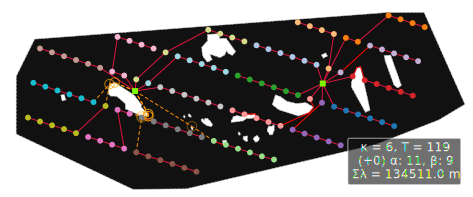

In [25]:
ax = gplot(H)

In [12]:
1 - 134511/162300

0.17121996303142328

In [30]:
with open('yi_2019_κ_6_radial_ours.dill', 'wb') as outfile:
    dill.dump(H, outfile)